In [1]:
import sys
import os

# Add the parent directory of 'station_focus' to sys.path
base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Parent directory
sys.path.append(base_path)
file_path = os.path.join(base_path, "data/boston/bike_trip_focused_data.parquet")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src import data_processing as dp
from src import utils
import geopandas as gpd

import seaborn as sns
from sklearn.ensemble import IsolationForest


In [2]:
station_data = dp.from_trip_to_station_focused(file_path)

In [3]:
station_data.columns

Index(['station_id', 'hour', 'dayofweek', 'month', 'is_start', 'count',
       'tripduration_mean', 'tripduration_std', 'tripduration_median',
       'distance_mean', 'distance_std', 'distance_median', 'speed_mean',
       'speed_std', 'speed_median', 'user_type_encoded_mean', 'temp_mean',
       'prcp_mean', 'wspd_mean', 'coco_mean', 'station_name', 'neighborhood',
       'geometry', 'nearby_transit_stops'],
      dtype='object')

# Temporal Analysis


The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



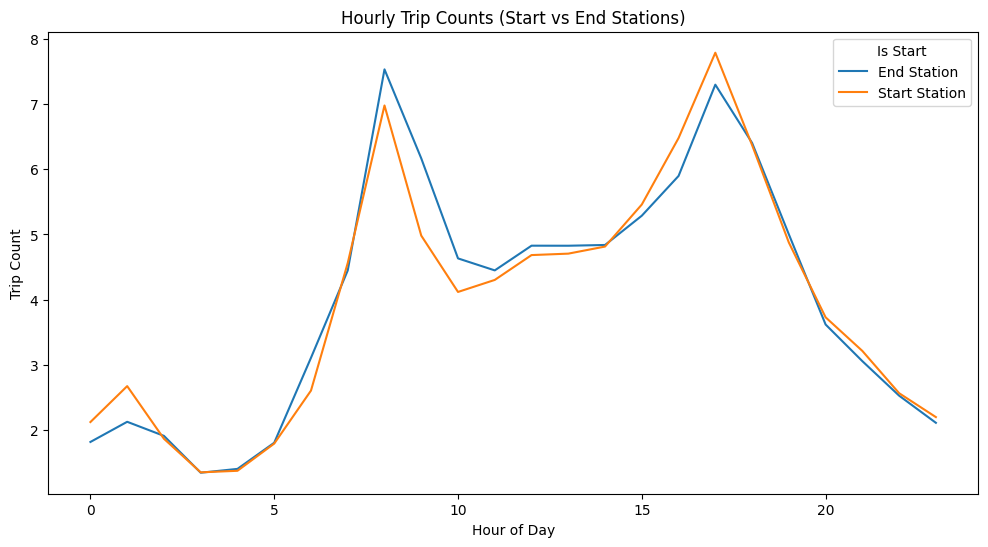

In [9]:
# Hourly analysis of trip counts
plt.figure(figsize=(12, 6))
sns.lineplot(data=station_data, x='hour', y='count', hue='is_start', ci=None)
plt.title('Hourly Trip Counts (Start vs End Stations)')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Count')
plt.legend(title="Is Start", labels=["End Station", "Start Station"])
plt.show()


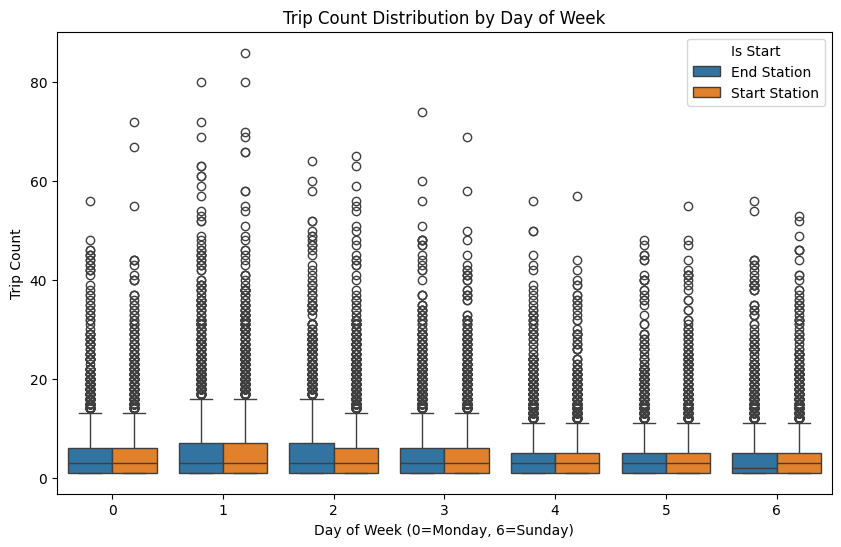

In [20]:
# Day-of-week analysis
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=station_data, x='dayofweek', y='count', hue='is_start')
plt.title('Trip Count Distribution by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Trip Count')
# Get the handles and labels from the plot
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Is Start", labels=["End Station", "Start Station"])
plt.show()


# Station-Specific Analysis

Top 10 Stations by Total Trip Count:
station_name
MIT at Mass Ave / Amherst St                   6807
Central Square at Mass Ave / Essex St          6160
MIT Vassar St                                  3977
Harvard Square at Mass Ave/ Dunster            3926
MIT Pacific St at Purrington St                3896
Forsyth St at Huntington Ave                   3339
Boylston St at Massachusetts Ave               3105
MIT Stata Center at Vassar St / Main St        3038
Charles Circle - Charles St at Cambridge St    2858
Mass Ave at Albany St                          2840
Name: count, dtype: int64

Bottom 10 Stations by Total Trip Count:
station_name
Community Life Center         1
Auburndale                    3
Cleary Sq                     3
Goodhue St at Grove St        3
Newton Library                4
Ross Playground               4
Blue Hill Ave at Almont St    5
Hyde Park Library             6
Langley Lot                   6
Beacon at Walnut              7
Name: count, dtype: int64


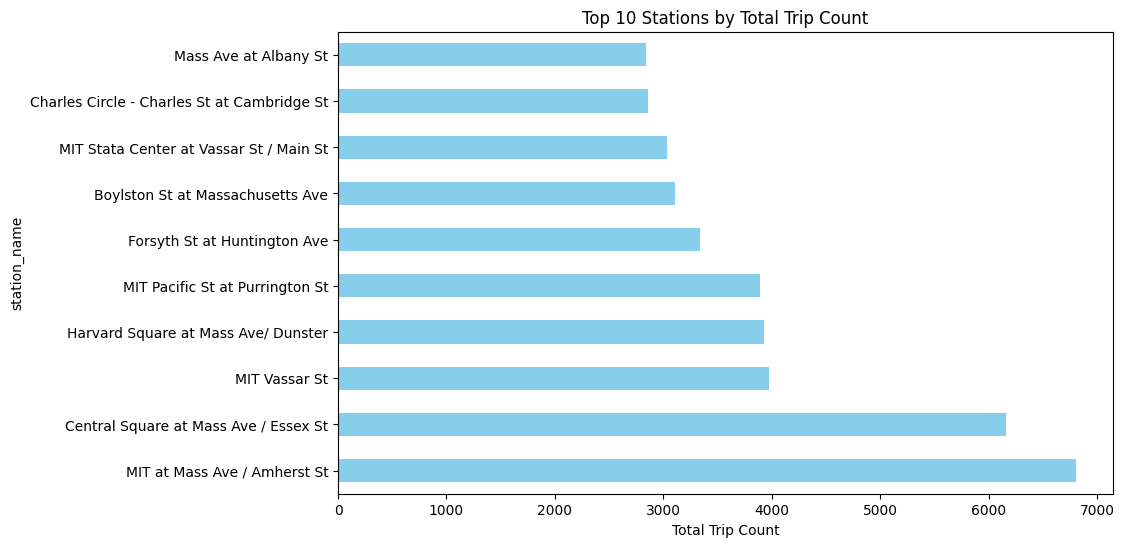

In [5]:
# Total counts by station
top_stations = station_data.groupby('station_name')['count'].sum().nlargest(10)
bottom_stations = station_data.groupby('station_name')['count'].sum().nsmallest(10)

print("Top 10 Stations by Total Trip Count:")
print(top_stations)

print("\nBottom 10 Stations by Total Trip Count:")
print(bottom_stations)

# Visualize top stations
top_stations.plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Top 10 Stations by Total Trip Count')
plt.xlabel('Total Trip Count')
plt.show()


# Start vs End Station Comparison

Mean Distance (Start vs End Stations):
is_start
0    1.919633
1    1.927939
Name: distance_mean, dtype: float64


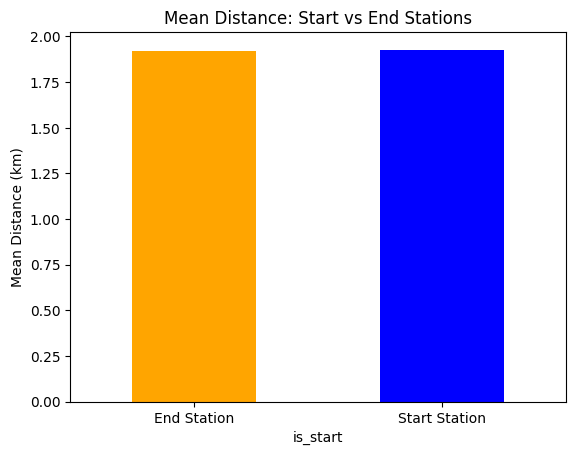

In [6]:
# Compare mean distance for start vs end stations
distance_comparison = station_data.groupby('is_start')['distance_mean'].mean()
print("Mean Distance (Start vs End Stations):")
print(distance_comparison)

# Plot comparison
distance_comparison.plot(kind='bar', color=['orange', 'blue'])
plt.title('Mean Distance: Start vs End Stations')
plt.xticks(ticks=[0, 1], labels=['End Station', 'Start Station'], rotation=0)
plt.ylabel('Mean Distance (km)')
plt.show()


# Weather Impact

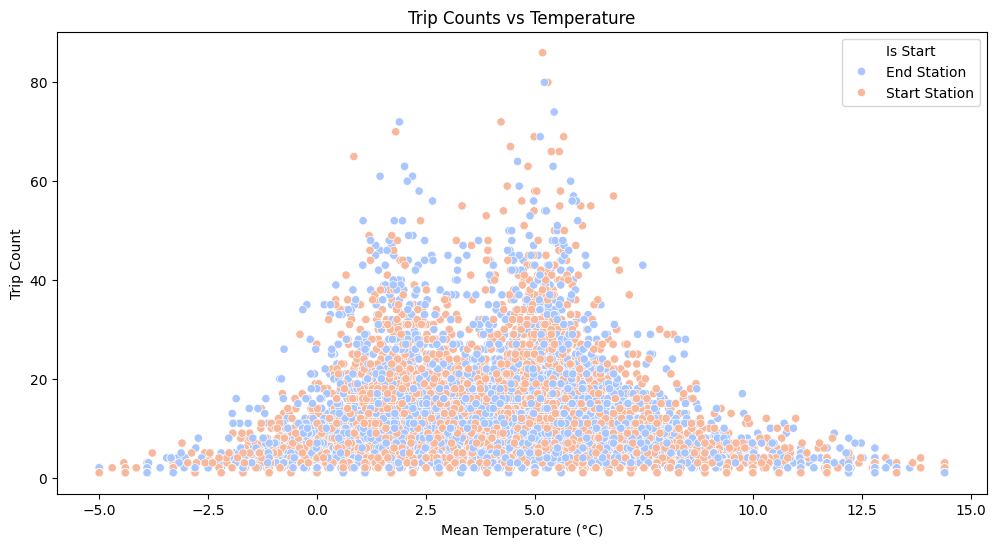

In [22]:
# Relationship between temperature and trip counts
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=station_data, x='temp_mean', y='count', hue='is_start', palette='coolwarm')
plt.title('Trip Counts vs Temperature')
plt.xlabel('Mean Temperature (°C)')
plt.ylabel('Trip Count')
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Is Start", labels=["End Station", "Start Station"])
plt.show()


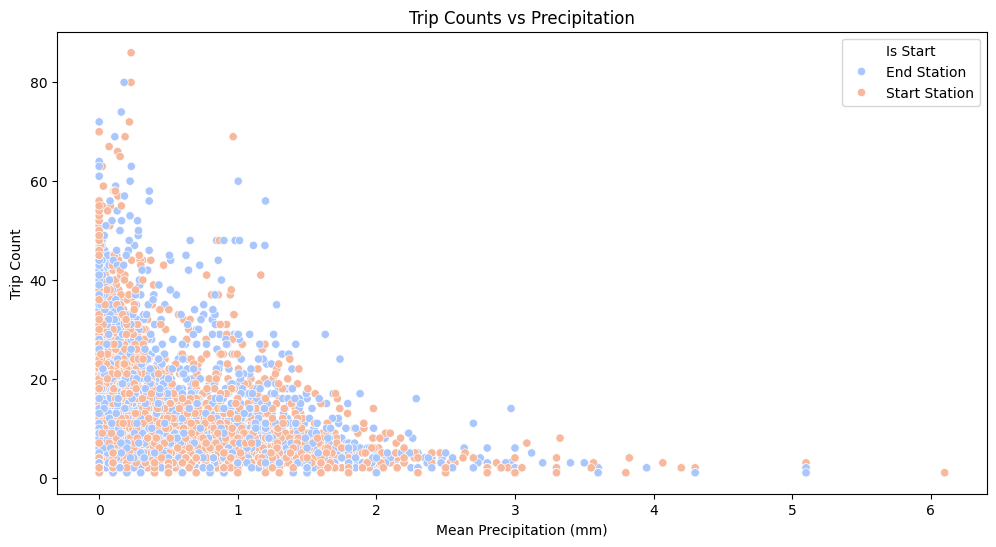

In [23]:
# Precipitation vs trip counts
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=station_data, x='prcp_mean', y='count', hue='is_start', palette='coolwarm')
plt.title('Trip Counts vs Precipitation')
plt.xlabel('Mean Precipitation (mm)')
plt.ylabel('Trip Count')
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Is Start", labels=["End Station", "Start Station"])
plt.show()


# Anomaly Analysis

In [49]:
# Select relevant features
features = [
    'count',                 # Core usage metric
    'distance_mean',         # Average trip distance
    'tripduration_mean',     # Average trip duration
    'speed_mean',            # Average trip speed
    'temp_mean',             # Weather impact
    'prcp_mean',             # Weather impact
    'wspd_mean',             # Weather impact
    'hour',                  # Temporal variation
    'dayofweek',             # Temporal variation
    'nearby_transit_stops'   # Station context
]
anomaly_data = station_data[features].fillna(0)

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
station_data['anomaly'] = iso_forest.fit_predict(anomaly_data)

# Analyze anomalies
anomalies = station_data[station_data['anomaly'] == -1]
print("Anomalies Detected:")
print(anomalies)


Anomalies Detected:
       station_id  hour  dayofweek  month  is_start  count  tripduration_mean  \
6               1     9          0      1         0      1             1243.0   
9               1    15          5      1         0      1            86016.0   
10              1    20          0      1         0      1            61813.0   
38              3     7          6      1         0      1             7353.0   
286             4     9          4      1         0      1              525.0   
...           ...   ...        ...    ...       ...    ...                ...   
58896         587    16          6      1         0      3             6211.0   
58897         587    16          6      1         1      2            10124.0   
58904         587    18          6      1         0      2            10124.0   
58952         590     9          4      1         0      1              298.0   
59073         590    23          6      1         1      1              179.0   

       

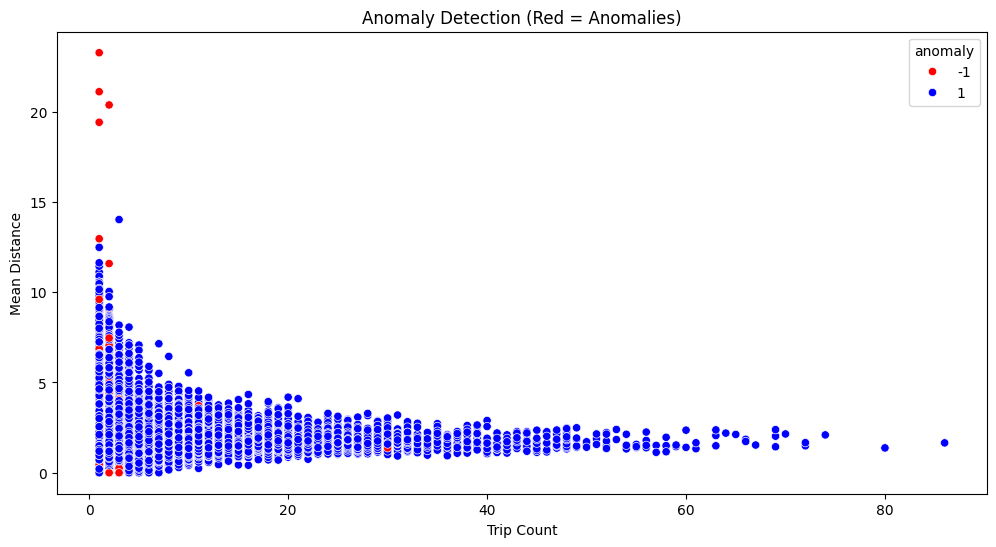

In [50]:
# Visualize anomalies
plt.figure(figsize=(12, 6))
sns.scatterplot(data=station_data, x='count', y='distance_mean', hue='anomaly', palette={1: 'blue', -1: 'red'})
plt.title('Anomaly Detection (Red = Anomalies)')
plt.xlabel('Trip Count')
plt.ylabel('Mean Distance')
plt.show()


## Pair Plot (Multi-Dimensional View)

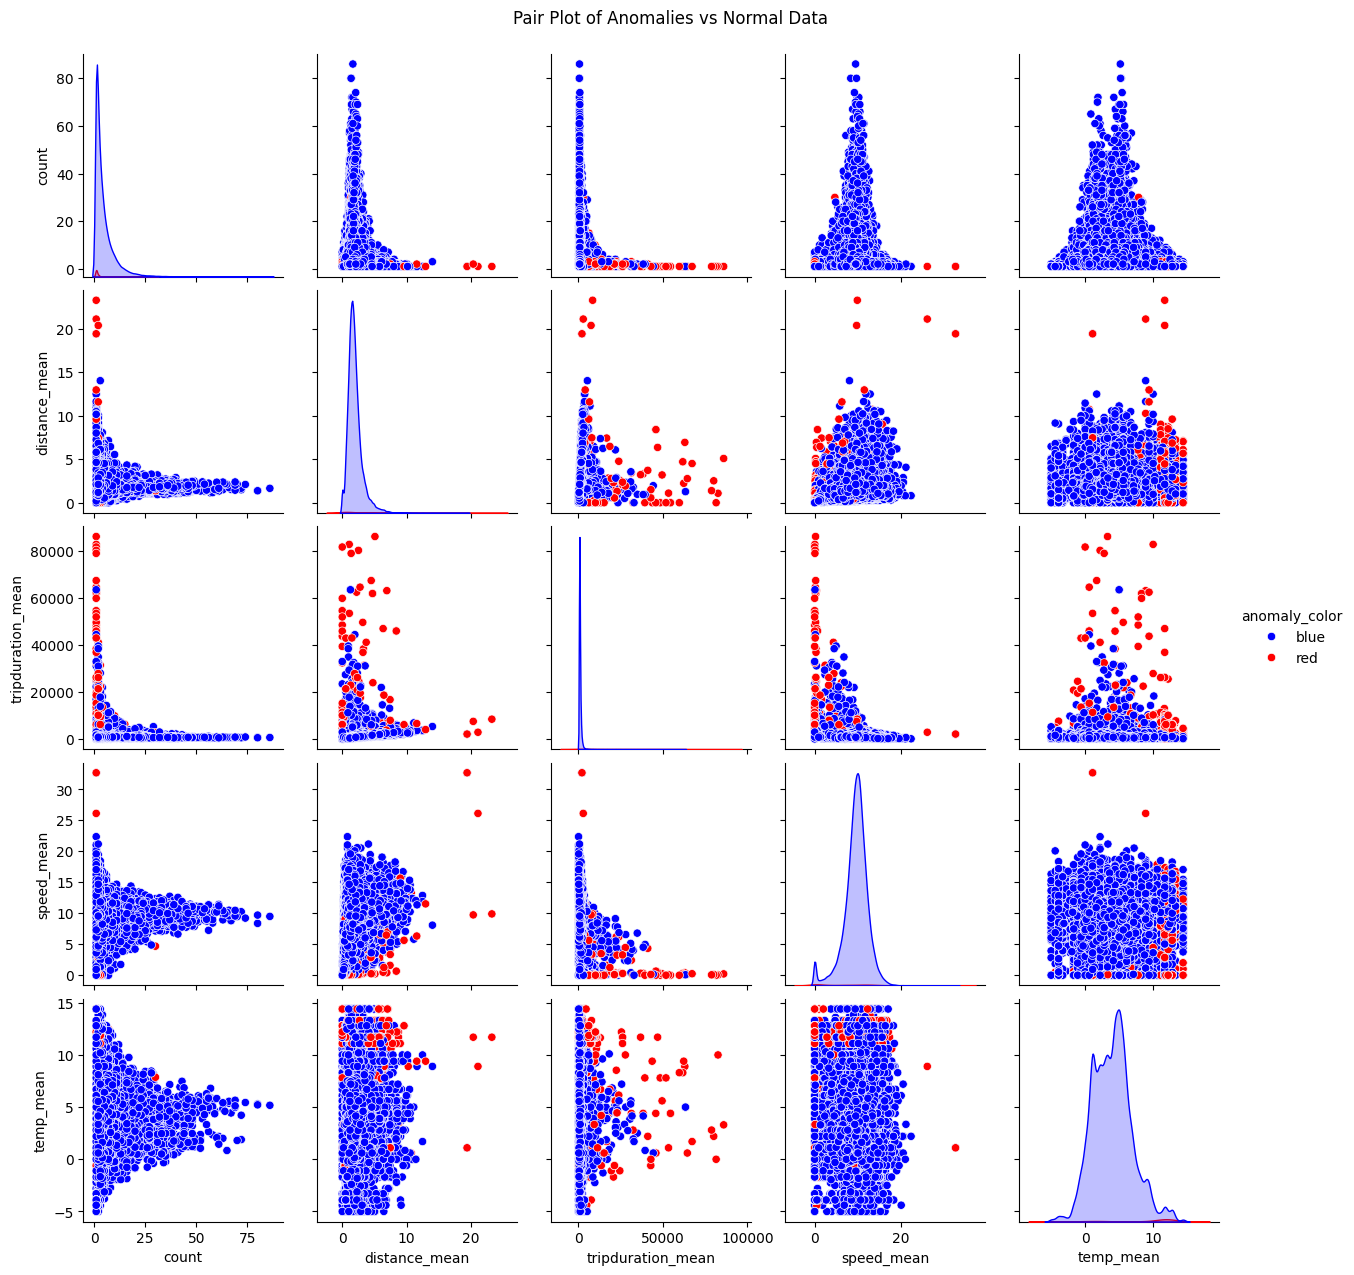

In [51]:
# Subset the data for pair plot visualization
features_for_pairplot = ['count', 'distance_mean', 'tripduration_mean', 'speed_mean', 'temp_mean']
station_data['anomaly_color'] = station_data['anomaly'].map({1: 'blue', -1: 'red'})

# Create pair plot with anomalies highlighted
sns.pairplot(station_data[features_for_pairplot + ['anomaly_color']], 
             hue='anomaly_color', palette={'blue': 'blue', 'red': 'red'})
plt.suptitle('Pair Plot of Anomalies vs Normal Data', y=1.02)
plt.show()

## Feature Distribution with Anomalies Highlighted

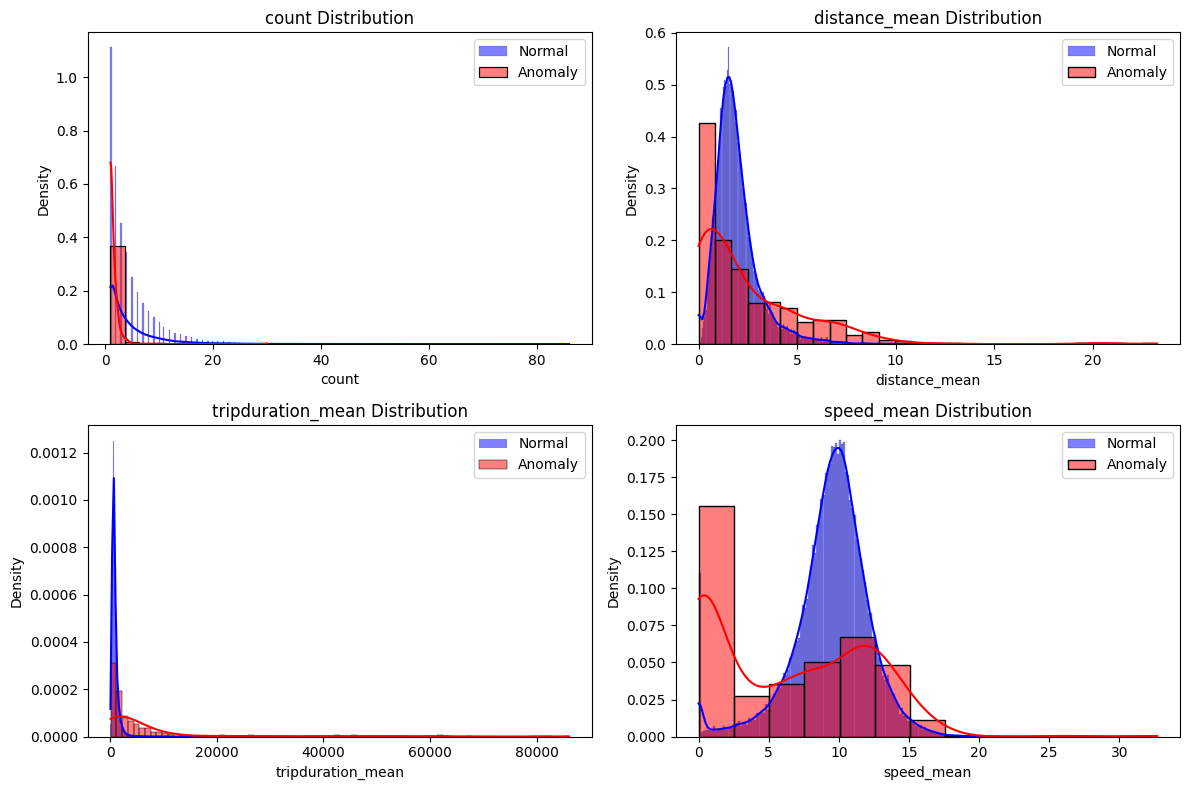

In [64]:
# Features to plot
features = ['count', 'distance_mean', 'tripduration_mean', 'speed_mean']

# Plot histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(station_data[station_data['anomaly'] == 1][feature], color='blue', label='Normal', kde=True, stat='density', ax=axes[i])
    sns.histplot(station_data[station_data['anomaly'] == -1][feature], color='red', label='Anomaly', kde=True, stat='density', ax=axes[i])
    axes[i].set_title(f'{feature} Distribution')
    axes[i].legend()

plt.tight_layout()
plt.show()

## Outlier Detection for Features

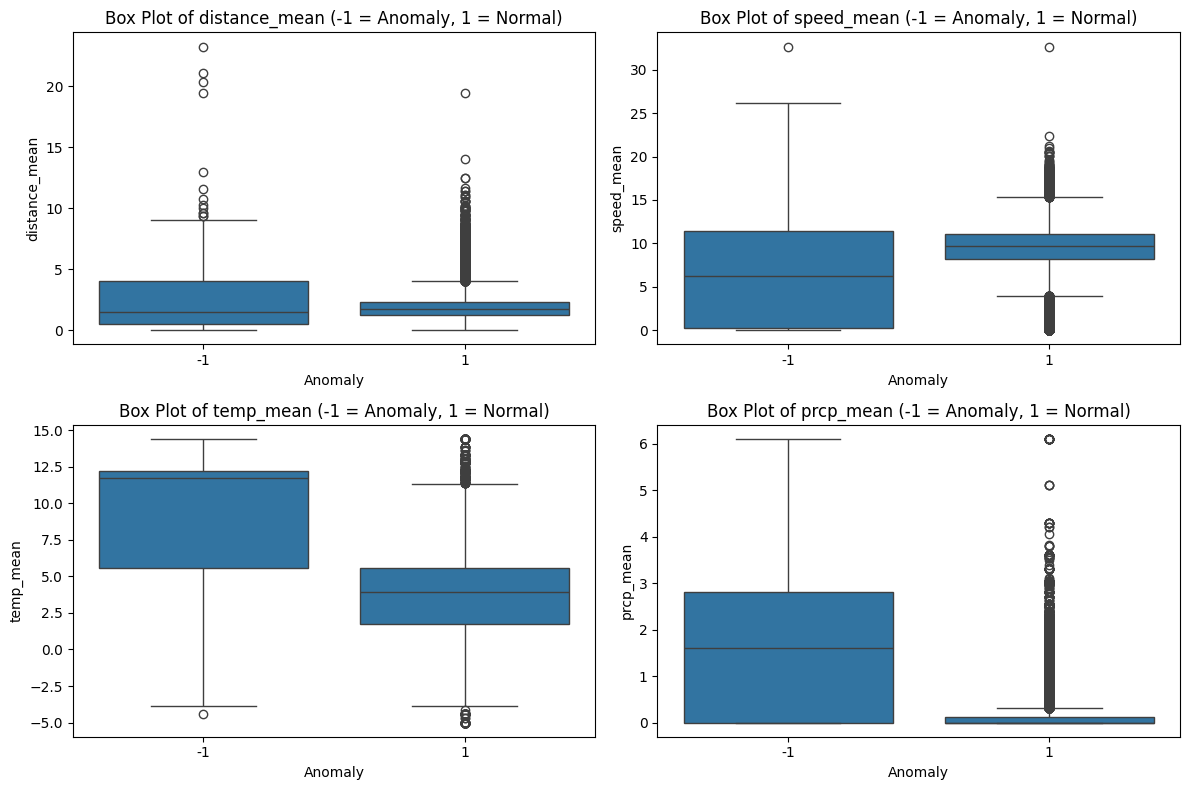

In [61]:
# Features to analyze
features = ['distance_mean', 'speed_mean', 'temp_mean', 'prcp_mean']

# Box plots for normal data and anomalies
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(data=station_data, x='anomaly', y=feature, ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature} (-1 = Anomaly, 1 = Normal)')
    axes[i].set_xlabel('Anomaly')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()


## Temporal Analysis (Line Plots Over Time)

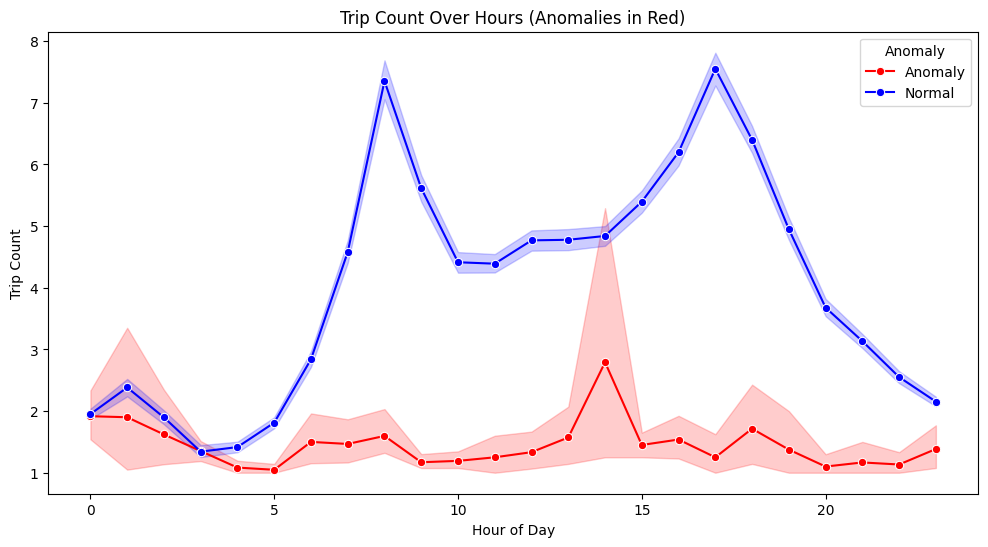

In [54]:
# Temporal visualization: Hour vs Trip Count
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=station_data, x='hour', y='count', hue='anomaly', 
             palette={1: 'blue', -1: 'red'}, marker='o')
plt.title('Trip Count Over Hours (Anomalies in Red)')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Count')
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Anomaly", labels=["Anomaly", "Normal"])
plt.show()


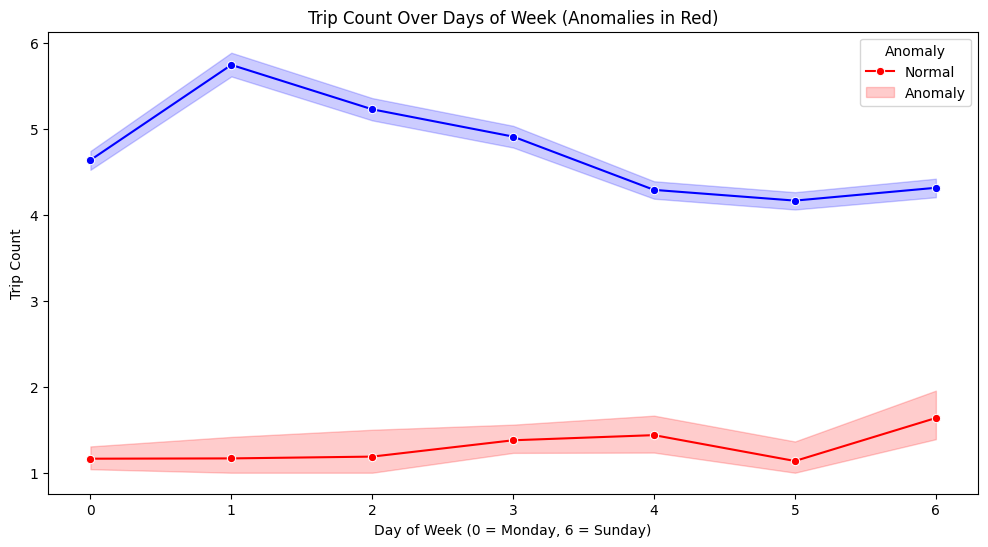

In [58]:
# Temporal Line Plot by Day of Week
plt.figure(figsize=(12, 6))
sns.lineplot(data=station_data, x='dayofweek', y='count', hue='anomaly',
             palette={1: 'blue', -1: 'red'}, marker='o')
plt.title('Trip Count Over Days of Week (Anomalies in Red)')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Trip Count')
plt.legend(title="Anomaly", labels=["Normal", "Anomaly"])
plt.show()